# 003. Web Search Rag with LangGraph

## Congifuration

In [22]:
from dotenv import load_dotenv
from tools import logging

import os

In [23]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
from dotenv import load_dotenv
import os
load_dotenv(override=True)

True

In [ ]:
from tools import logging
logging.langsmith("web-search-RAG")

LangSmith is tracing....
[Project Name]
quary-rewrite-RAG


## PDF Retrieval Chain

In [2]:
from tools.pdf import PDFRetrievalChain

pdf = PDFRetrievalChain(["data/Deepseek-r1.pdf"]).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

# 1. State Definition

In [4]:
from typing import Annotated, TypedDict, List
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    # question: Annotated[str, "Question"] 
    question: Annotated[List[str], add_messages]
    context: Annotated[str, "Context"] 
    answer: Annotated[str, "Answer"]  
    messages: Annotated[list, add_messages]    
    
    relevance: Annotated[str, "Relevance"]

# 2. Node Definition

In [17]:
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import messages_to_history
from langchain_teddynote.tools.tavily import TavilySearch
from tools.utils import format_docs


# 1. Retrieve Node
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs = format_docs(retrieved_docs)

    return {"context": retrieved_docs}


# 2. Answer Node
def llm_answer(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    context = state["context"]
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [18]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Query Rewrite Prompt
with open("prompts/query_rewrite.txt", "r", encoding="utf-8") as f:
    template = f.read()

re_write_prompt = PromptTemplate(
    template=template,
    input_variables=["question"]
)

question_rewriter = (
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()
)

In [19]:
# Query Rewrite Node
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return {"question": question_rewritten}

In [20]:
from tools.evaluator import GroundednessChecker

# Relevance Check Node
def relevance_check(state: GraphState) -> GraphState:

    question_answer_relevant = GroundednessChecker(
        llm=ChatOpenAI(model="gpt-4o-mini", temperature=0), target="question-retrieval"
    ).create()

    response = question_answer_relevant.invoke(
        {"question": state["question"][-1].content, "context": state["context"]}
    )

    return {"relevance": response.score}


def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

In [21]:
def web_search(state: GraphState) -> GraphState:
    tavily_tool = TavilySearch()

    latest_question = state["question"][-1].content

    search_result = tavily_tool.search(
        query=latest_question,   # ✅ 문자열만 전달
        topic="general",
        max_results=6,
        format_output=True,
    )

    return {"context": search_result}

# 3. Edges

In [22]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Query Rewrite Node
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)
workflow.add_node("web_search", web_search)

workflow.add_edge("query_rewrite", "retrieve")
workflow.add_edge("retrieve", "relevance_check") 

workflow.add_conditional_edges(
    "relevance_check", 
    is_relevant,
    {
        "relevant": "llm_answer",  
        "not relevant": "web_search", 
    },
)

workflow.add_edge("web_search", "llm_answer") 
workflow.add_edge("llm_answer", END)  

workflow.set_entry_point("query_rewrite")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

# 4. Graph Visualization

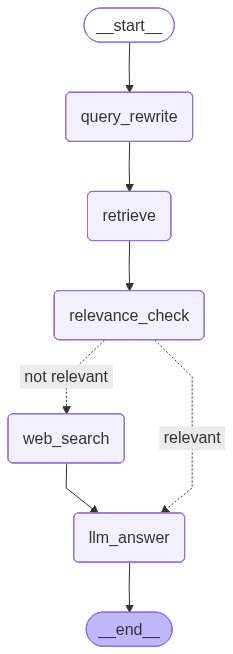

In [23]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)


# 5. Graph Execution

In [24]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

inputs = GraphState(question="What is DeepSeek-R1-Zero?")
invoke_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
What is the DeepSeek-R1-Zero technology?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>solvingcomplexproblems,resultinginthedevelopmentofDeepSeek-R1-Zero. DeepSeek-
R1-Zero demonstrates capabilities such as self-verification, reflection, and generating
longCoTs,markingasignificantmilestonefortheresearchcommunity. Notably,itisthe</content><source>data/Deepseek-r1.pdf</source><page>4</page></document>
<document><content>spontaneousdevelopmentsignificantlyenhancesDeepSeek-R1-Zero’sreasoningcapabilities,
enablingittotacklemorechallengingtaskswithgreaterefficiencyandaccuracy.
AhaMomentofDeepSeek-R1-Zero Aparticularlyintriguingphenomenonobservedduring</content><source>data/Deepseek-r1.pdf</source><page>8</page></document>
<document><content>abilityofDeepSeek-R1-Zerotoachievesuchcompetitiveperformance,bothwithandwithout
majority voting, highlights its stro

In [25]:
stream_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What is the DeepSeek-R1-Zero technology?
🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"yes"}
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
DeepSeek-R1-Zero is a technology that showcases advanced capabilities such as self-verification, reflection, and generating long Chains of Thought (CoTs). It enhances reasoning capabilities, enabling it to tackle challenging tasks with greater efficiency and accuracy, and achieves competitive performance without the need for supervised fine-tuning data, relying solely on reinforcement learning (RL).

**Source**
- data/Deepseek-r1.pdf (page 4)
- data/Deepseek-r1.pdf (page 7)
- data/Deepseek-r1.pdf (page 8)

In [29]:
inputs = GraphState(question="what is CeADAR, Ireland?")
invoke_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
question:
What is the CeADAR initiative in Ireland?

🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>engineeringtasks. Asaresult,DeepSeek-R1hasnotdemonstratedahugeimprovement
over DeepSeek-V3 on software engineering benchmarks. Future versions will address
thisbyimplementingrejectionsamplingonsoftwareengineeringdataorincorporating
asynchronousevaluationsduringtheRLprocesstoimproveefficiency.
16</content><source>data/Deepseek-r1.pdf</source><page>16</page></document>
<document><content>Contents
1 Introduction 3
1.1 Contributions . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4
1.2 SummaryofEvaluationResults . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4
2 Approach 5</content><source>data/Deepseek-r1.pdf</source><page>2</page></document>
<document><content>datasetisevaluatedusingproblemsfrom10Div.2contestsalongwithexpert

In [30]:
stream_graph(app, inputs, config)


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
What is the CeADAR initiative in Ireland?
🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"score":"no"}
🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
CeADAR is Ireland's national center for applied AI, functioning as a not-for-profit technology center focused on innovation, applied R&D, and translational R&D in AI, machine learning, and data analytics. It provides proofs of concept, market-ready solutions, funding assistance, training programs, and access to computing resources, supporting businesses in leveraging AI technologies.

**Source**
- [CeADAR: Ireland's Centre for Applied AI](https://european-digital-innovation-hubs.ec.europa.eu/edih-catalogue/ceadar-irelands-centre-applied-ai)
- [CeADAR | Ireland's Centre for AI](https://ceadar.ie/)

In [ ]:
outputs = app.get_state(config).values
outputs

{'question': [HumanMessage(content='What is DeepSeek-R1-Zero?', additional_kwargs={}, response_metadata={}, id='47bd2823-a866-462e-9c84-24cad1d33a2b'),
  HumanMessage(content='What is the DeepSeek-R1-Zero technology?', additional_kwargs={}, response_metadata={}, id='c852a558-825a-4d46-91c5-e47bbe6862a1'),
  HumanMessage(content='What is DeepSeek-R1-Zero?', additional_kwargs={}, response_metadata={}, id='36386b61-7af8-44ed-a392-7beb0f04ca0f'),
  HumanMessage(content='What is the DeepSeek-R1-Zero technology?', additional_kwargs={}, response_metadata={}, id='0a9e1048-7bcd-4ec4-8742-b5fb7e78e43a'),
  HumanMessage(content='When was Llama3 published', additional_kwargs={}, response_metadata={}, id='f6895bde-1741-4074-ad39-78f07e970293'),
  HumanMessage(content='"When was the Llama3 model released?"', additional_kwargs={}, response_metadata={}, id='6506c9bc-8e14-4d5b-aa17-ccc030ae3414')],
 'context': ['<document><title>为什么when后面引导的从句没有主语的时候里面的动词一定是非谓 …</title><url>https://www.zhihu.com/questi